In [1]:
import polars as pl
import pandas as pd
import arviz as az
import bambi as bmb
import numpy as np
from plotnine import *
import pymc as pm

In [2]:
file = '/Users/zweli/Documents/old_mac_desktop/cricket_testmatch_data.parquet'

create_ballnumber_column = pl.col('ball').rank().over(['match_id', 'striker', 'innings']).cast(pl.Int16).sub(1).alias('ballnumber')
create_cumruns_column = pl.col('runs_off_bat').cumsum().over(['match_id', 'striker', 'innings']).alias('cumruns')

df = (pl
    .read_parquet(file)
    .select(['match_id', 'season', 'start_date', 'batting_team', 'striker', 'innings', 'ball', 'runs_off_bat'])
    .sort(by=['match_id', 'striker', 'innings', 'ball'])
    .with_columns([create_ballnumber_column, create_cumruns_column, pl.col('match_id').add('_').add(pl.col('innings')).alias('innings_id')])
    .sort(by=['match_id', 'batting_team', 'striker', 'innings', 'ball'])
    .filter(pl.col('ballnumber').is_in(np.arange(0, (6*200)+1, 6*1)))
    .filter(pl.col('start_date').dt.year().is_in([np.arange(2015, 2017,1)]))
    .filter(pl.col('batting_team').is_in(["South Africa"]))
    .filter(pl.col('innings_id').n_unique().over('striker').ge(30))
    .select(['cumruns', 'striker', 'ballnumber', 'innings_id'])
    )

df.head()

cumruns,striker,ballnumber,innings_id
i64,str,i16,str
0,"""D Elgar""",0,"""1000851_1"""
1,"""D Elgar""",6,"""1000851_1"""
9,"""D Elgar""",12,"""1000851_1"""
11,"""D Elgar""",18,"""1000851_1"""
0,"""D Elgar""",0,"""1000851_3"""


In [3]:
data = df.to_pandas()

fml = 'cumruns ~ 1 + (1|striker) + (1|striker:ballnumber)'

model = bmb.Model(fml, family='negativebinomial', data=data)

model

       Formula: cumruns ~ 1 + (1|striker) + (1|striker:ballnumber)
        Family: negativebinomial
          Link: mu = log
  Observations: 25294
        Priors: 
    target = mu
        Common-level effects
            Intercept ~ Normal(mu: 0.0, sigma: 2.5)
        
        Group-level effects
            1|striker ~ Normal(mu: 0.0, sigma: HalfNormal(sigma: 2.5))
            1|striker:ballnumber ~ Normal(mu: 0.0, sigma: HalfNormal(sigma: 2.5))
        
        Auxiliary parameters
            cumruns_alpha ~ HalfCauchy(beta: 1.0)

In [4]:
df.groupby(['striker', 'innings_id']).agg(pl.col('ballnumber').max()).sort(by=['striker', 'innings_id'])\
    .groupby('striker').agg(pl.col('innings_id').n_unique().alias('innings'), pl.col('ballnumber').sum().alias('balls_faced')).head()

striker,innings,balls_faced
str,u32,i64
"""M Morkel""",104,1512
"""DW Steyn""",114,2370
"""GC Smith""",163,11928
"""HE van der Dus…",32,2112
"""M Ntini""",68,636


In [5]:
fit = model.fit(inference_method='vi', n_init=100_000, obj_optimizer=pm.adagrad_window(learning_rate=1e-2)).sample(1_000)

#fit = model.fit(inference_method='vi', n_init=100_000, obj_optimizer=pm.adagrad_window(learning_rate=1e-2)).sample(1_000)
#fit = model.fit(inference_method='vi', method="svgd", inf_kwargs=dict(n_particles=1000), obj_optimizer=pm.sgd(learning_rate=0.01)).sample(1000)
#fit = model.fit(nuts_sampler='numpyro', include_mean=True, cores=20, chains=4)

fit

Finished [100%]: Average Loss = 89,533


Inference data with groups:
	> posterior
	> observed_data

In [6]:
df_predict = df.select('striker').with_columns(key=1).unique().with_columns(key=1).join(df.select('ballnumber').unique().with_columns(key=1), how='inner', on='key').drop('key').to_pandas()
#df_predict = df.select(pl.col(['striker', 'ballnumber'])).unique().sort(by=['striker', 'ballnumber']).to_pandas()

df_predict.head()

,striker,ballnumber
0,D Elgar,0
1,D Elgar,6
2,D Elgar,12
3,D Elgar,18
4,D Elgar,24


In [7]:
model.predict(fit, data=df_predict, kind='pps', include_group_specific=True)

In [8]:
df_predictions = (az.summary(fit, var_names=['cumruns_mean'], kind='stats')
                  #az.summary(fit.posterior_predictive, var_names=['cumruns'], kind='stats')
                  .set_axis(['mean', 'sd', 'lower', 'upper'], axis='columns')
                  .reset_index(drop=True)
                  .merge(df_predict, left_index=True, right_index=True)
                  )

df_predictions.head()

,mean,sd,lower,upper,striker,ballnumber
0,0.481,0.068,0.350,0.596,D Elgar,0
1,3.006,0.187,2.671,3.367,D Elgar,6
2,6.629,0.361,5.994,7.310,D Elgar,12
3,9.410,0.490,8.506,10.357,D Elgar,18
4,12.652,0.721,11.348,14.015,D Elgar,24


/opt/homebrew/Caskroom/mambaforge/base/envs/bambi/lib/python3.10/site-packages/plotnine/guides/guides.py:187: PlotnineWarning: Cannot generate legend for the 'color' aesthetic. Make sure you have mapped a variable to it


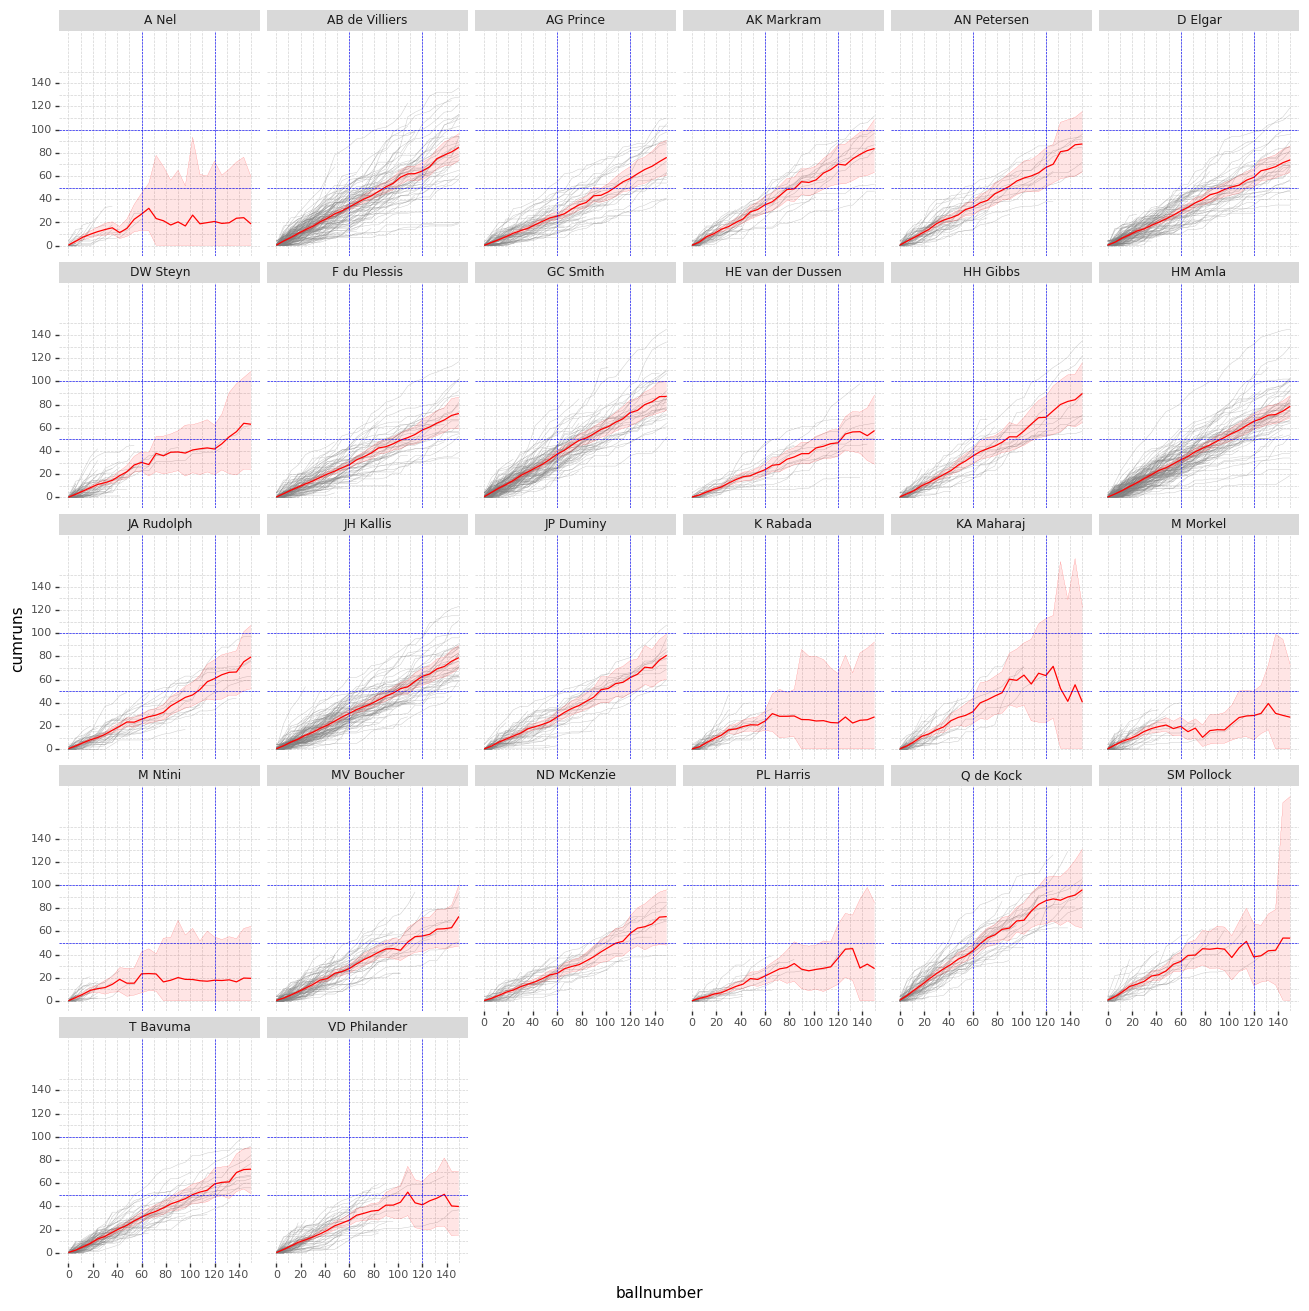

<ggplot: (929431492)>

In [10]:
balls = (150)+1
estimate_color='red'

personal_theme = theme(dpi=100,
                       figure_size=(4*4,4*4),
                       axis_text=element_text(size=8), 
                       panel_background=element_rect(fill='white'),
                       panel_grid=element_line(color='lightgray', size=.5, linetype='dashed')
                       )

chart_long = (ggplot() + 
              scale_color_brewer(type='qual', palette=4) +
              geom_line(df.filter(pl.col('ballnumber').le(balls)), aes(x='ballnumber', y='cumruns', group='innings_id'), color='gray', alpha=.4, size=.2) +
              geom_ribbon(df_predictions.query('ballnumber <= @balls'), aes(x='ballnumber', ymin='lower', ymax='upper'), color=estimate_color, fill=estimate_color, alpha=.1,  size=.05, outline_type='both') +
              geom_line(df_predictions.query('ballnumber <= @balls'), aes(x='ballnumber', y='mean'), color=estimate_color, size=.5) +
              geom_hline(yintercept=100, color='blue', linetype='dashed', size=.25) +
              geom_hline(yintercept=50, color='blue', linetype='dashed', size=.25) +
              geom_vline(xintercept=60, color='blue', linetype='dashed', size=.25) +
              geom_vline(xintercept=120, color='blue', linetype='dashed', size=.25) +
              scale_x_continuous(breaks=range(0, balls, 20)) +
              scale_y_continuous(breaks=range(0, 150, 20)) +
              facet_wrap('striker', ncol=6, scales=['fixed']) +
              personal_theme
              )

chart_long